In [18]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error

In [19]:
# Load dataset (Make sure to upload 'leak_data.csv' to Colab)
from google.colab import files
uploaded = files.upload()

Saving simulated_pipeline_data_with_leak_rate.csv to simulated_pipeline_data_with_leak_rate (1).csv


In [20]:
df = pd.read_csv('simulated_pipeline_data_with_leak_rate.csv')

# Data Preprocessing
# Drop null values
df.dropna(inplace=True)

In [21]:
print(df.isnull().sum())
print(df.describe())

Time         0
CH4L         0
CH4R         0
P            0
RsL          0
RsR          0
Leak         0
Leak_Rate    0
dtype: int64
               CH4L          CH4R             P           RsL           RsR  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      11.471067     11.521850     48.683229    102.421951    102.562695   
std        4.932888      4.993651      6.212950     12.450477     12.569279   
min        2.155199      2.287249     21.729915     55.343961     57.046090   
25%        8.821319      8.822609     45.171042     93.992618     94.199840   
50%       10.294375     10.283867     49.259891    101.336839    101.428515   
75%       11.937652     11.979957     52.883527    109.312619    109.491035   
max       35.764640     33.741153     68.458123    154.129083    155.624529   

               Leak     Leak_Rate  
count  10000.000000  10000.000000  
mean       0.100000      0.448487  
std        0.300015      1.457329  
min        

In [22]:
df_cleaned = df.dropna()
print(df_cleaned.isnull().sum())
print(df_cleaned.shape)

Time         0
CH4L         0
CH4R         0
P            0
RsL          0
RsR          0
Leak         0
Leak_Rate    0
dtype: int64
(10000, 8)


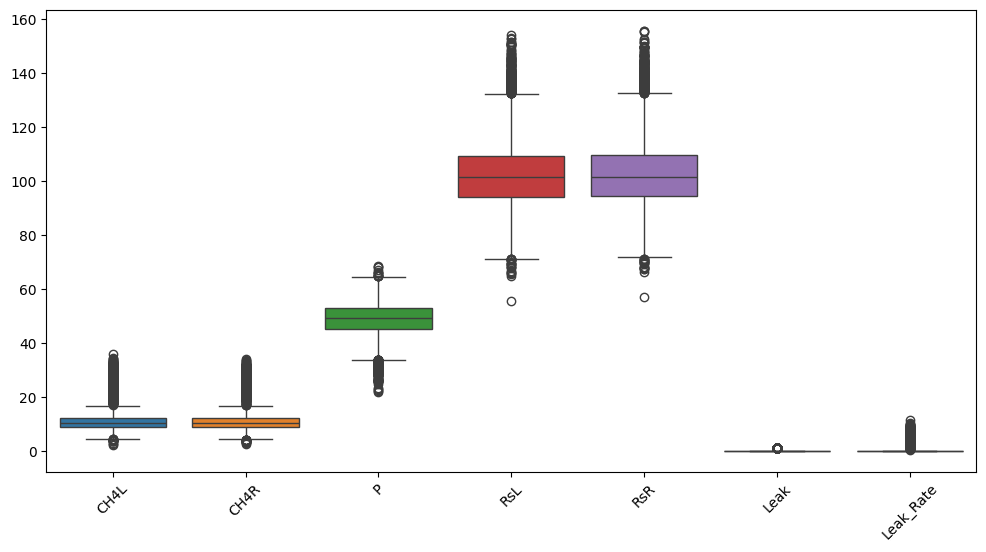

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.boxplot(data=df_cleaned)
plt.xticks(rotation=45)
plt.show()

In [31]:
import numpy as np

# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Compute IQR
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Compute outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
df_cleaned = df[~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)]

# Get the count of remaining rows for each column
output = df_cleaned.count()

print(output)

Time         8888
CH4L         8888
CH4R         8888
P            8888
RsL          8888
RsR          8888
Leak         8888
Leak_Rate    8888
dtype: int64


In [25]:
scaler = StandardScaler()
df[['CH4L', 'CH4R', 'P', 'RsL', 'RsR']] = scaler.fit_transform(df[['CH4L', 'CH4R', 'P', 'RsL', 'RsR']])

In [26]:
# Extract features and targets
features = df[['CH4L', 'CH4R', 'P', 'RsL', 'RsR']]
leak_target = df['Leak']  # Binary classification target
leak_rate_target = df['Leak_Rate']  # Regression target

# Split data into training and testing sets
X_train, X_test, y_train_leak, y_test_leak = train_test_split(features, leak_target, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_rate, y_test_rate = train_test_split(features, leak_rate_target, test_size=0.2, random_state=42)

In [27]:
leak_detection_model = RandomForestClassifier(n_estimators=100, random_state=42)
leak_detection_model.fit(X_train, y_train_leak)
leak_predictions = leak_detection_model.predict(X_test)
print(f'Leak Detection Accuracy: {accuracy_score(y_test_leak, leak_predictions):.2f}')

# Train Leak Rate Model (Regression)
leak_rate_model = RandomForestRegressor(n_estimators=100, random_state=42)
leak_rate_model.fit(X_train_reg, y_train_rate)
leak_rate_predictions = leak_rate_model.predict(X_test_reg)
print(f'Leak Rate Mean Absolute Error: {mean_absolute_error(y_test_rate, leak_rate_predictions):.2f}')

Leak Detection Accuracy: 1.00
Leak Rate Mean Absolute Error: 0.04


In [28]:
# Save the trained models
joblib.dump(leak_detection_model, 'leak_detection_model.pkl')
joblib.dump(leak_rate_model, 'leak_rate_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Load the trained models
leak_detection_model = joblib.load('leak_detection_model.pkl')
leak_rate_model = joblib.load('leak_rate_model.pkl')
scaler = joblib.load('scaler.pkl')

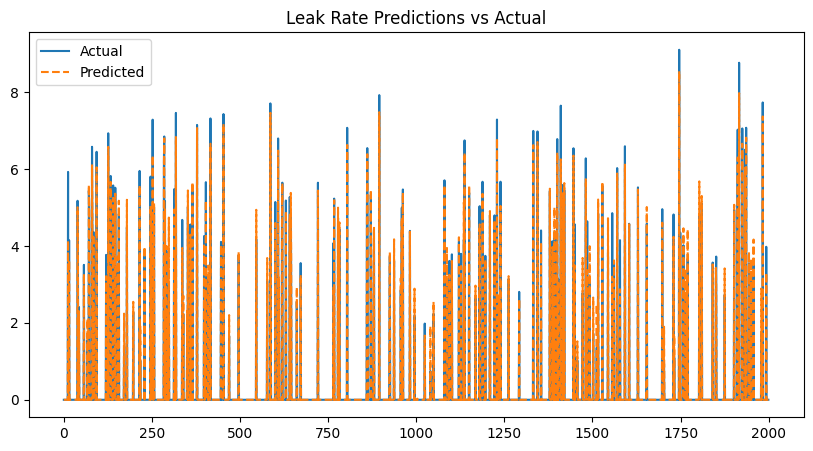

In [29]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rate.values, label="Actual")
plt.plot(leak_rate_predictions, label="Predicted", linestyle="dashed")
plt.legend()
plt.title("Leak Rate Predictions vs Actual")
plt.show()

In [30]:
# User input for real-time prediction
print("Enter sensor values for leak detection:")
CH4L = float(input("CH4L: "))
CH4R = float(input("CH4R: "))
P = float(input("P: "))
RsL = float(input("RsL: "))
RsR = float(input("RsR: "))

# Create a DataFrame for the input
test_input = pd.DataFrame([[CH4L, CH4R, P, RsL, RsR]], columns=['CH4L', 'CH4R', 'P', 'RsL', 'RsR'])

# Apply scaling
test_input = scaler.transform(test_input)

# Predict leak detection
leak_prediction = leak_detection_model.predict(test_input)[0]

# Predict leak rate if a leak is detected
if leak_prediction == 1:
    leak_rate = leak_rate_model.predict(test_input)[0]
    print(f"Leak detected, Estimated Leak Rate: {leak_rate:.2f}")
else:
    print("No Leak")


Enter sensor values for leak detection:


KeyboardInterrupt: Interrupted by user